# Analysis - Experiment 5: IT Split Range

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
import scipy.stats as ss

def rescale_ioi(ioi):
    """
    Calculates location of an IOI on a 0-100 scale. Appears in the manuscript
    as Equation 1.

    This conversion assumes that 0=275ms and 100=1100ms, given
    that a 275 ms IOI is a rate twice as fast as the metronome and a 1100 ms
    IOI is a rate half as fast as the metronome.
    """
    ioi = 100 * np.log(1100 / ioi) / np.log(1100 / 275) 
    return np.round(ioi, 5)

# Define levels of conditions
IOI_LEVELS = [1000, 918, 843, 774, 710, 652, 599, 550, 504,
              463, 425, 390, 358, 329, 302]
TEMPO_BINS = [(1000, 918, 843), (774, 710, 652), (599, 550, 504),
              (463, 425, 390), (358, 329, 302)]
PITCH_LEVELS = [2, 3, 4, 5, 6, 7]
LOUDNESS_LEVELS = [0, 1, 2]

# Calculate "correct" ratings for each IOI and tempo range
CORRECT_RATINGS = [rescale_ioi(ss.gmean(iois)) for iois in TEMPO_BINS]
CORRECT_RATINGS_FULL = [rescale_ioi(ioi) for ioi in IOI_LEVELS]

# Set file paths
DATAFILE = '../data/response_data.csv'
SURVEYFILE = '../data/survey_responses.csv'
EXCFILE = '../data/excluded.txt'
FIGURE_PATH = './figures/'

# Adjust matplotlib settings
plt.rc('figure', titlesize=32)  # fontsize of the figure title
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=23)    # fontsize of the tick labels
plt.rc('ytick', labelsize=23)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

# Load data
data = pd.read_csv(DATAFILE)

# Remove excluded participants
excluded = np.loadtxt(EXCFILE, dtype=int)
data = data[~np.isin(data.subject, excluded)]

# Exclude outlier trials
data = data[data.cooks <= 4 / 180]

# Raw Tempo Ratings

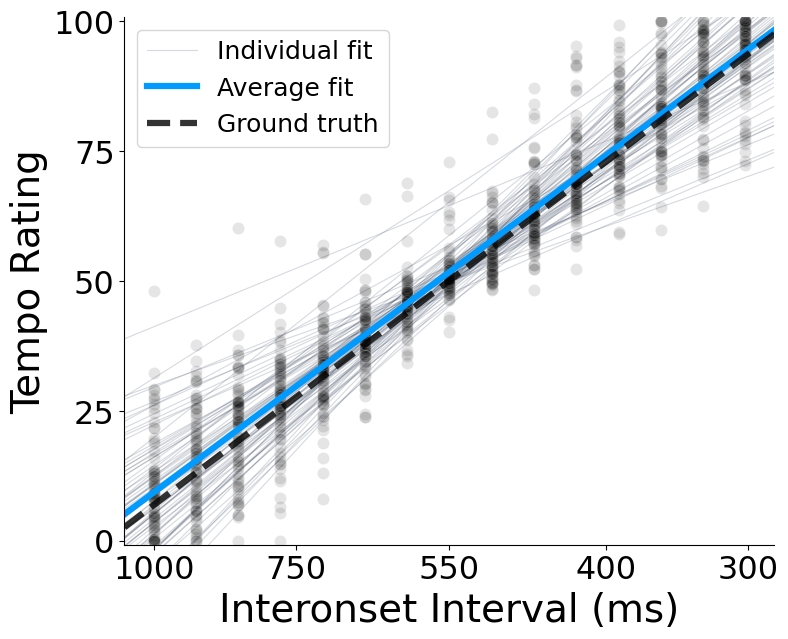

In [2]:
# Get subject averages
subj_avg = data.groupby(['subject', 'ioi']).response.mean().reset_index()
subj_slopes = data.groupby('subject').slope.mean().reset_index()
subj_intercepts = data.groupby('subject').intercept.mean().reset_index()

plt.figure()

# Scatterplot
ax = sns.scatterplot(x=np.log(1/subj_avg.ioi), y='response', data=subj_avg, alpha=.1, color='k', s=75, zorder=1)

# Individual subject fits
for i in range(len(subj_slopes)):
    slope = subj_slopes.iloc[i, 1]
    intercept = subj_intercepts.iloc[i, 1]
    if i == 0:
        plt.axline((np.log(1/IOI_LEVELS[0]), intercept + slope *  np.log(IOI_LEVELS[0])), 
                   (np.log(1/IOI_LEVELS[-1]), intercept + slope * np.log(IOI_LEVELS[-1])), 
                   c='#33425b', ls='-', alpha=.2, zorder=0, lw=.8, label='Individual fit')
    else:
        plt.axline((np.log(1/IOI_LEVELS[0]), intercept + slope * np.log(IOI_LEVELS[0])), 
                   (np.log(1/IOI_LEVELS[-1]), intercept + slope * np.log(IOI_LEVELS[-1])), 
                   c='#33425b', ls='-', alpha=.2, zorder=0, lw=.8)
        
# Average of all subject fits
inter = subj_intercepts.intercept.mean()
slope = subj_slopes.slope.mean()
plt.axline((np.log(1/IOI_LEVELS[0]), inter + slope * np.log(IOI_LEVELS[0])), (np.log(1/IOI_LEVELS[-1]), inter + slope * np.log(IOI_LEVELS[-1])), 
           c='#019aff', ls='-', alpha=1, label='Average fit', lw=4.5, zorder=2)

# Ground truth line
plt.axline((np.log(1/IOI_LEVELS[0]), CORRECT_RATINGS_FULL[0]), (np.log(1/IOI_LEVELS[-1]), CORRECT_RATINGS_FULL[-1]), 
           c='k', ls='--', alpha=.8, label='Ground truth', lw=4.5, zorder=2)

plt.xlabel('Interonset Interval (ms)')
plt.ylabel('Tempo Rating')
plt.yticks(range(0, 101, 25))
plt.xticks(np.log(1/np.array([1000, 750, 550, 400, 300])))
ax.set_xticklabels(np.array([1000, 750, 550, 400, 300]), rotation=0)
plt.ylim(-.8, 100.8)
plt.legend()

plt.gcf().set_size_inches(8, 6.5)
plt.tight_layout()

plt.gcf().savefig(FIGURE_PATH + 'raw_ratings5.svg')

# Effect of Pitch and Tone Type

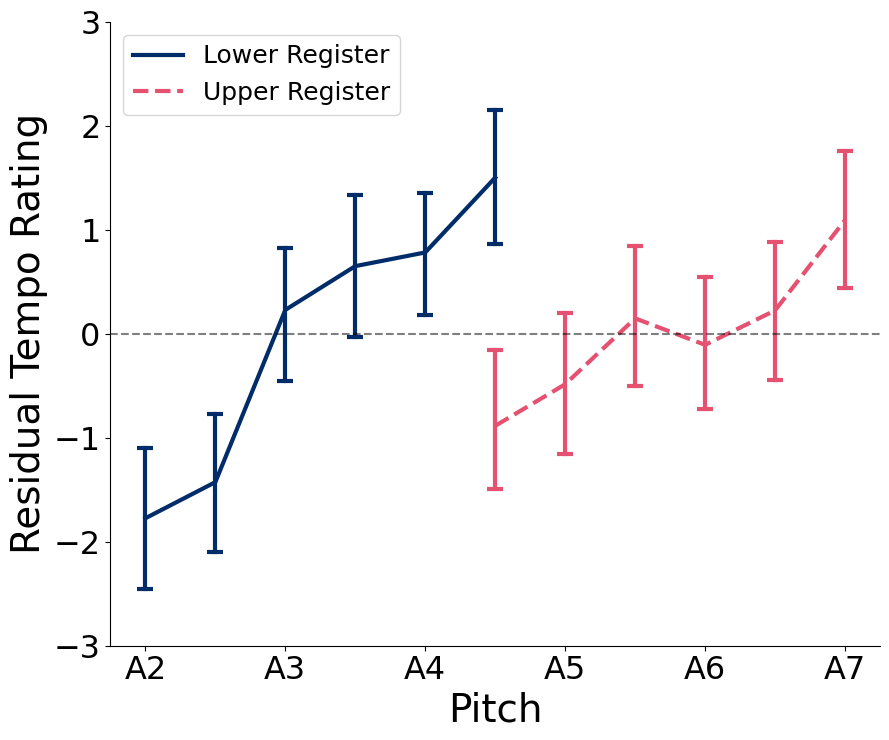

In [3]:
plt.figure()
sns.lineplot(x=data.pitch, y='residual', data=data[data.range==0], color='#002c6a', ls='-',
             marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=3, label='Lower Register')
sns.lineplot(x=data.pitch+5, y='residual', data=data[data.range==1], color='#e45171', ls='--',
             marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=3, label='Upper Register')
plt.axhline(0, ls='--', c='k', alpha=.5)
plt.ylim(-3, 3)
plt.xticks(range(0, 11, 2), ['A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
plt.xlabel('Pitch')
plt.ylabel('Residual Tempo Rating')
plt.legend(loc=2)
plt.gcf().set_size_inches(9, 7.5)
plt.tight_layout()
plt.gcf().savefig(FIGURE_PATH + 'pitch5.svg')

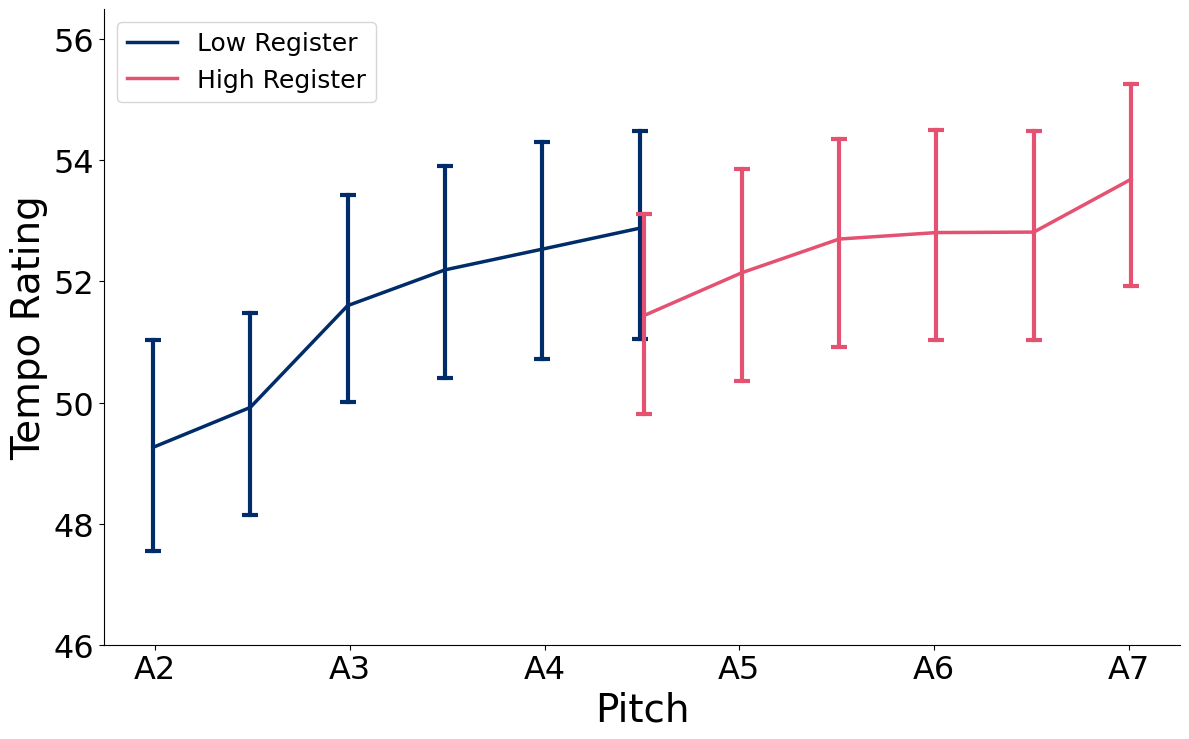

In [4]:
plt.figure()
sns.lineplot(x=data.pitch-.025, y='response', data=data[data.range==0], color='#002c6a', 
             marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=2.5, label='Low Register')
ax=sns.lineplot(x=data.pitch+5.025, y='response', data=data[data.range==1], color='#e45171', 
             marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=2.5, label='High Register')
plt.xlabel('Pitch Level')
plt.ylabel('Tempo Rating')
plt.ylim(46, 56.5)
plt.xticks([0, 2, 4, 6, 8, 10], ['A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
plt.xlabel('Pitch')

plt.gcf().set_size_inches(12, 7.5)
plt.tight_layout()
plt.gcf().savefig(FIGURE_PATH + 'raw_pitch5.svg')

# Survey Analysis

Please note that in order to preserve participant privacy, survey responses have not been made open access. Please contact the authors for access to data regarding demographics and musical experience.

In [5]:
# Load survey data and rename ID to subject
surv = pd.read_csv(SURVEYFILE)
surv.rename(columns={'id':'subject'}, inplace=True)

# Get list of subjects included in analyses
subj_list = data.subject.unique()

# Select only survey responses from participants included in analyses
surv = surv[np.in1d(surv.subject, subj_list)]
surv.reset_index()

# Add column indicating whether the participant was in the low or high range condition
surv['range'] = np.array([data[data.subject == s].range.iloc[0] for s in surv.subject])

# Print age stats
print('Minimum Age:', surv.age.min())
print('Maximum Age:', surv.age.max())
print('Mean Age:', surv.age.mean())
print('StdDev Age:', surv.age.std())

# Print gender stats
print('Number of Males:', np.sum(surv.gender == 'Male'))
print('Number of Females:', np.sum(surv.gender == 'Female'))
print('Number not reported:', np.sum(surv.gender== 'Prefer not to answer'))
print('Number self-described:', np.sum(surv.gender == 'Other'))
print('Self-descriptions:', [g for g in surv['gender[other]'] if type(g) == str])
print('Number of Low Females:', np.sum((surv.gender == 'Female') & (surv.range == 0)))
print('Number of Low Males:', np.sum((surv.gender == 'Male') & (surv.range == 0)))
print('Number of High Females:', np.sum((surv.gender == 'Female') & (surv.range == 1)))
print('Number of High Males:', np.sum((surv.gender == 'Male') & (surv.range == 1)))

Minimum Age: 17.0
Maximum Age: 41.0
Mean Age: 19.144736842105264
StdDev Age: 3.014206130391751
Number of Males: 11
Number of Females: 64
Number not reported: 0
Number self-described: 1
Self-descriptions: ['Non-binary assigned female at birth']
Number of Low Females: 33
Number of Low Males: 4
Number of High Females: 31
Number of High Males: 7
